# Training a Classifier


## About data

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, There's a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

Here we will use the **CIFAR10 dataset**. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of **size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.**

![CIFAR10](https://pytorch.org/tutorials/_images/cifar10.png)

## Training an image classifier

Do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalizing CIFAR10

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]. 

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Trainset 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


See some of the training images:

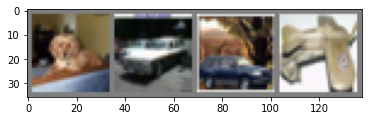

  dog   car   car plane


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Get random training images
data_iter = iter(trainloader)
images, labels = data_iter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a CNN

In [0]:
 import torch.nn as nn
 import torch.nn.functional as F

 class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [0]:
net = Net()

### 3. Define a loss function and optimizer

Here we use a classification Cross-Entropy loss and SGD with momentum.

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

Loop over our data iterator, and feed the inputs to the network and optimize.

In [25]:
%timeit 

for epoch in range(2): # loop over the dataset multiple times
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):

    # data is a list of [inputs, labels]
    inputs, labels = data

    # Zero the parameters gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1}], loss: {running_loss / 2000}')
      running_loss = 0.0

print('Finished Training')

[1, 2000], loss: 2.1826980512738228
[1, 4000], loss: 1.861397951722145
[1, 6000], loss: 1.675633091583848
[1, 8000], loss: 1.5680936317741871
[1, 10000], loss: 1.4962861561961471
[1, 12000], loss: 1.4720259196609258
[2, 2000], loss: 1.4045349027439953
[2, 4000], loss: 1.3766244593188166
[2, 6000], loss: 1.3211331495419145
[2, 8000], loss: 1.324923539839685
[2, 10000], loss: 1.2800088016055524
[2, 12000], loss: 1.28645165797323
Finished Training


Save the trained model:

In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

We need to check if the network has learnt anything at all. 

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Let's display an image from the test set to get familiar:

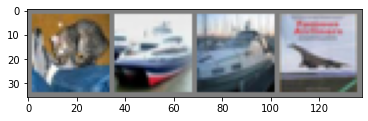

Ground truth: ['cat', 'ship', 'ship', 'plane']


In [27]:
data_iter = iter(testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print(f'Ground truth: {[classes[labels[i]] for i in range(4)]}')

Load back in our saved model:

In [28]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Use our model to predict:

In [29]:
outputs = net(images)
outputs

tensor([[-1.3561, -1.0716,  0.0595,  3.8110, -0.0888,  2.5238,  0.9873, -0.3858,
         -1.0139, -2.6577],
        [ 4.0611,  3.8548, -0.8280, -2.6504, -1.8869, -4.9093, -2.8940, -4.9433,
          6.7974,  1.8927],
        [ 2.1525,  1.8603, -0.2923, -1.3524, -0.6429, -2.8142, -1.5261, -2.3020,
          3.3195,  0.8072],
        [ 3.9415,  0.9628,  0.9712, -2.2351, -1.0913, -4.4380, -2.6259, -4.3544,
          6.1612,  0.4256]], grad_fn=<AddmmBackward>)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. 

Get the index of the highest energy:

In [30]:
_, predicted = torch.max(outputs, 1)

print(f'Predicton: {[classes[predicted[i]] for i in range(4)]}')

Predicton: ['cat', 'ship', 'ship', 'ship']


Look at how the network performs on the whole dataset.

In [31]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Furthermore, let's see which class that performed well and which didn't.

In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

print('Accuracy:')
for i in range(10):
  print(f'{classes[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracy:
plane: 50.7%
car: 75.6%
bird: 44.1%
cat: 52.3%
deer: 50.6%
dog: 43.7%
frog: 55.7%
horse: 61.3%
ship: 77.3%
truck: 41.3%


### Training on GPU

Just like how transfering a Tensor onto the GPU, we can transfer the neural net onto the GPU.

First define our device as the first visible cuda device if we have CUDA available:

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [34]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Remember to send the inputs and targets at every step to the GPU too:

In [35]:
%timeit 

# Train on GPU

for epoch in range(2): # loop over the dataset multiple times
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):

    # data is a list of [inputs, labels]
    # send the inputs and targets to GPU
    inputs, labels = data[0].to(device), data[1].to(device)

    # Zero the parameters gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1}], loss: {running_loss / 2000}')
      running_loss = 0.0

print('Finished Training')


[1, 2000], loss: 1.1906330567151309
[1, 4000], loss: 1.1891084057092667
[1, 6000], loss: 1.1927897964864969
[1, 8000], loss: 1.171304252818227
[1, 10000], loss: 1.1996155543327331
[1, 12000], loss: 1.1739462814182042
[2, 2000], loss: 1.200210980847478
[2, 4000], loss: 1.1862565385699273
[2, 6000], loss: 1.1758401057869197
[2, 8000], loss: 1.1840295707434416
[2, 10000], loss: 1.1780272368341684
[2, 12000], loss: 1.194015095025301
Finished Training


Notice that if the network is small, using GPU won't give up a MASSIVE speedup compared to CPU.